In [36]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import GRUCell
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms.functional as F
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import make_grid
from torchvision.ops import sigmoid_focal_loss
from torchvision.transforms.functional import convert_image_dtype
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import pl_bolts
from pl_bolts.models.vision import UNet

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import torchmetrics as tm

from torchinfo import summary

import random

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

import os

In [37]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# 1. Preparation

## 1.1 DataModule

In [71]:
batch_size = 8
num_workers = 4

In [72]:
class RoadSatelliteSet(Dataset):
    def __init__(self, dataset, transform_img=None, transform_tuple=None):
        self.dataset = dataset
        
        self.transform_img = transform_img
        self.transform_tuple = transform_tuple

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        
        if self.transform_img:
            img = self.transform_img(img)
            
        if self.transform_tuple:
            img, mask = self.transform_tuple(img, mask)

        return (img, mask)

In [73]:
def rotation_tuple(img_tuple): 
        angle = T.RandomRotation(degrees=(0, 360)).get_params([0, 360])
        
        img_rot = TF.rotate(img_tuple[0], angle)
        mask_rot = TF.rotate(img_tuple[1], angle)
    
        return (img_rot, mask_rot)

In [74]:
class RoadSatelliteModule(pl.LightningDataModule):
    def prepare_data(self):
        self.train_images = self.read_images('train/images/', ImageReadMode.RGB)
                
        self.train_masks = self.read_images('train/groundtruth/', ImageReadMode.GRAY)
    
        for i, train_mask in enumerate(self.train_masks):
            self.train_masks[i][self.train_masks[i] > 0] = 1
            
        self.train_zip = list(zip(self.train_images, self.train_masks))
        
        self.test_images = self.read_images('test/', ImageReadMode.RGB)

        
    def setup(self, stage=None):
        if stage in (None, 'fit'): 
            train_length = int(len(self.train_zip) * 0.8)
            valid_length = len(self.train_zip) - train_length

            self.train_data, self.valid_data = random_split(self.train_zip, [train_length, valid_length])
            
            self.train_dataset = RoadSatelliteSet(self.train_data, transforms_img, randomAugmentations)
            self.valid_dataset = RoadSatelliteSet(self.valid_data, transforms_img)
            
        if stage in (None, 'test'):
            self.test_data = self.test_images
            
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            num_workers=num_workers,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset, 
            num_workers=num_workers,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
         )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_data, 
            num_workers=num_workers,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
        )
    
    def read_images(self, data_dir, read_mode):
        return [read_image(data_dir + file, read_mode) for file in os.listdir(data_dir)]

In [75]:
transforms_img = T.Compose(
    [
        T.RandomEqualize(p=1.0),
        T.GaussianBlur(3, 5),
        T.RandomAdjustSharpness(3, 1),
    ]
)

In [76]:
def randomAugmentations(img, mask):    
    if random.random() > 0.5:
        angle = T.RandomRotation(degrees=(0, 360)).get_params([0, 360])

        img = TF.rotate(img, angle)
        mask = TF.rotate(mask, angle)
        
    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = TF.hflip(mask)
        
    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)
        
    return img, mask

In [77]:
road_data = RoadSatelliteModule()

In [78]:
road_data.prepare_data()
road_data.setup()

In [79]:
X, y = next(iter(road_data.train_dataloader()))

## 1.2 Inspect data

In [80]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

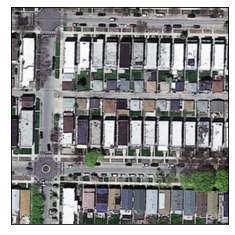

In [81]:
show_image(X[2])

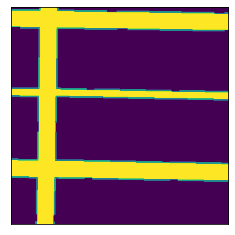

In [82]:
show_image(y[2])

In [83]:
seg_images = [draw_segmentation_masks(train_pair[0], train_pair[1].bool()) for train_pair in road_data.train_zip]

In [84]:
#for seg_image in seg_images:
#    show_image(seg_image)

In [85]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# 2. System

In [105]:
class SemanticSegmentationSystem(pl.LightningModule):
    def __init__(self, model: nn.Module, datamodule: pl.LightningDataModule, lr: float = 1e-3, batch_size: int = batch_size):
        super().__init__()
        
        self.model = model
        self.datamodule = datamodule
        
        self.lr = lr
        self.batch_size = batch_size
        
        self.dice_loss = DiceLoss()

    def training_step(self, batch, batch_idx):
        X, y = batch
        
        X = X.float()
        y = y.float()
        
        y_pred = self.model(X)
       
        #loss = sigmoid_focal_loss(y_pred, y, reduction='mean')
        #loss = nn.functional.binary_cross_entropy_with_logits(y_pred, y, reduction='mean')
        #loss = sigmoid_focal_loss(y_pred, y, reduction='mean') + nn.functional.binary_cross_entropy_with_logits(y_pred, y, reduction='mean')
        loss = self.dice_loss(y_pred, y) + nn.functional.binary_cross_entropy_with_logits(y_pred, y, reduction='mean')
        
        self.log('training_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
                
        X = X.float()
        y = y.int()
        
        y_pred = self.model(X)
        y_sig = torch.sigmoid(y_pred)
       
        metric = tm.functional.accuracy(y_sig, y, average='samples')
        
        self.log('validation_metric', metric)
        
        return metric
    
    def test_step(self, batch, batch_idx):
        X, _ = batch
        
        return self.model(X)
    
    @torch.no_grad()
    def visualize_results(self):
        Xs, ys = next(iter(self.val_dataloader()))
                
        y_preds = torch.sigmoid(self.model(X.float()))
        
        for y_pred in y_preds:
            show_image(y_pred)
           
    @torch.no_grad()
    def visualize_results_overlay(self):
        Xs, ys = next(iter(self.val_dataloader()))
                
        y_preds = torch.sigmoid(self.model(Xs.float()))
        
        pred_zip = list(zip(Xs, y_preds))
        
        seg_images = [draw_segmentation_masks(train_pair[0], train_pair[1].round().bool(), colors=['#00ff00']) for train_pair in pred_zip]
        
        for seg_image in seg_images:
            show_image(seg_image)
            
    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

    def test_dataloader(self):
        return self.datamodule.test_dataloader()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=2)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 2, 1e-6, verbose=2)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'validation_metric'
        }

# 3. Model

In [106]:
class SDNCell(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gru = GRUCell(input_size=3*num_features, hidden_size=num_features)

    def forward(self, neighboring_features, features):
        """ Update current features based on neighboring features """
        return self.gru(torch.cat(neighboring_features, dim=1), features)


class _CorrectionLayer(nn.Module):

    def __init__(self, num_features, dir=0):
        super().__init__()
        self.num_features = num_features
        self.cell = SDNCell(num_features)
        if dir == 0:
            self.forward = self.forward0
        elif dir == 1:
            self.forward = self.forward1
        elif dir == 2:
            self.forward = self.forward2
        else:
            self.forward = self.forward3
        self.zero_pad = None

    def _get_zero_pad(self, batch, device):
        if self.zero_pad is None or self.zero_pad.shape[0] != batch:
            self.zero_pad = torch.zeros((batch, self.num_features, 1), device=device)  # no grad ??
        return self.zero_pad

    def forward0(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d - 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward1(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d + 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward2(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, d - 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward3(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, d + 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features


class SDNLayer(nn.Module):
    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        # project-in network
        cnn_module = nn.ConvTranspose2d if 2 else nn.Conv2d
        self.project_in_stage = cnn_module(in_ch, num_features, kernel_size, stride, padding)
        # correction network
        sdn_correction_layers = []
        for dir in dirs:
            sdn_correction_layers.append(_CorrectionLayer(num_features, dir=dir))
        self.sdn_correction_stage = nn.Sequential(*sdn_correction_layers)
        # project-out network
        self.project_out_stage = nn.Conv2d(num_features, out_ch, 1)

    def forward(self, x):
        # (I) project-in stage
        x = self.project_in_stage(x)
        x = torch.tanh(x)
        # (II) correction stage
        x = x.contiguous(memory_format=torch.channels_last)
        x = self.sdn_correction_stage(x)
        x = x.contiguous(memory_format=torch.contiguous_format)
        # (III) project-out stage
        x = self.project_out_stage(x)
        return x


class ResSDNLayer(nn.Module):

    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        self.sdn = SDNLayer(in_ch, 2 * out_ch, num_features, dirs, kernel_size, stride, padding, upsample)
        cnn_module = nn.ConvTranspose2d if upsample else nn.Conv2d
        self.cnn = cnn_module(in_ch, out_ch, kernel_size, stride, padding)

    def forward(self, input):
        cnn_out = self.cnn(input)
        sdn_out, gate = self.sdn(input).chunk(2, 1)
        gate = torch.sigmoid(gate)
        return gate * cnn_out + (1-gate) * sdn_out

In [107]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out
    
class VGGSpatialBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, upsample=False):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        
        self.spatial = ResSDNLayer(middle_channels, out_channels, 16, range(4), 3, 1, 1, upsample)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        #out = self.conv2(out)
        out = self.spatial(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [108]:
class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        nb_filter = [16, 32, 64, 128, 256, 512]
        
        down_upsample = False
        up_upsample = True

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.spatial0_0 = VGGSpatialBlock(input_channels, nb_filter[0], nb_filter[0], down_upsample)
        
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.spatial1_0 = VGGSpatialBlock(nb_filter[0], nb_filter[1], nb_filter[1], down_upsample)
        
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.spatial2_0 = VGGSpatialBlock(nb_filter[1], nb_filter[2], nb_filter[2], down_upsample)

        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.spatial3_0 = VGGSpatialBlock(nb_filter[2], nb_filter[3], nb_filter[3], down_upsample)
        
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])
        self.spatial4_0 = VGGSpatialBlock(nb_filter[3], nb_filter[4], nb_filter[4], down_upsample)
        
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.spatial3_1 = VGGSpatialBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3], up_upsample)
        
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.spatial2_2 = VGGSpatialBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2], up_upsample)
        
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.spatial1_3 = VGGSpatialBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1], up_upsample)

        self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.spatial0_4 = VGGSpatialBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0], up_upsample)

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        #x0_0 = self.conv0_0(input)
        x0_0 = self.spatial0_0(input)
        
        x1_0 = self.conv1_0(self.pool(x0_0))
        #x1_0 = self.spatial1_0(self.pool(x0_0))

        #x2_0 = self.conv2_0(self.pool(x1_0))
        x2_0 = self.spatial2_0(self.pool(x1_0))
        
        #x3_0 = self.conv3_0(self.pool(x2_0))
        x3_0 = self.spatial3_0(self.pool(x2_0))
        
        #x4_0 = self.conv4_0(self.pool(x3_0))
        x4_0 = self.spatial4_0(self.pool(x3_0))
        
        #x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x3_1 = self.spatial3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        
        #x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x2_2 = self.spatial2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1)) 
        #x1_3 = self.spatial1_3(torch.cat([x1_0, self.up(x2_2)], 1))  

        #x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))
        x0_4 = self.spatial0_4(torch.cat([x0_0, self.up(x1_3)], 1))
        
        output = self.final(x0_4)
        return output

In [109]:
class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [16, 32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.spatial2_0 = VGGSpatialBlock(nb_filter[1], nb_filter[2], nb_filter[2], False)
        
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.spatial3_0 = VGGSpatialBlock(nb_filter[2], nb_filter[3], nb_filter[3], False)

        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])
        self.spatial4_0 = VGGSpatialBlock(nb_filter[3], nb_filter[4], nb_filter[4], False)

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.spatial2_1 = VGGSpatialBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2], True)

        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.spatial3_1 = VGGSpatialBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3], True)

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])
        self.spatial2_2 = VGGSpatialBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2], True)

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        #x2_0 = self.conv2_0(self.pool(x1_0))
        x2_0 = self.spatial2_0(self.pool(x1_0))

        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        #x3_0 = self.conv3_0(self.pool(x2_0))
        x3_0 = self.spatial3_0(self.pool(x2_0))

        #x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x2_1 = self.spatial2_1(torch.cat([x2_0, self.up(x3_0)], 1))

        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        #x4_0 = self.conv4_0(self.pool(x3_0))
        x4_0 = self.spatial4_0(self.pool(x3_0))
        
        #x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x3_1 = self.spatial3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        #x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x2_2 = self.spatial2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [110]:
torch.cuda.empty_cache()

In [111]:
model = NestedUNet(1, 3).cuda()

In [112]:
summary(model, input_size=(8, 3, 400, 400))

Layer (type:depth-idx)                                  Output Shape              Param #
NestedUNet                                              --                        --
├─VGGBlock: 1-1                                         [8, 16, 400, 400]         --
│    └─Conv2d: 2-1                                      [8, 16, 400, 400]         448
│    └─BatchNorm2d: 2-2                                 [8, 16, 400, 400]         32
│    └─ReLU: 2-3                                        [8, 16, 400, 400]         --
│    └─Conv2d: 2-4                                      [8, 16, 400, 400]         2,320
│    └─BatchNorm2d: 2-5                                 [8, 16, 400, 400]         32
│    └─ReLU: 2-6                                        [8, 16, 400, 400]         --
├─MaxPool2d: 1-2                                        [8, 16, 200, 200]         --
├─VGGBlock: 1-3                                         [8, 32, 200, 200]         --
│    └─Conv2d: 2-7                                      

In [113]:
X, y = next(iter(road_data.train_dataloader()))

In [114]:
y_pred = model(X[:2].float().cuda())

In [115]:
y_pred.shape

torch.Size([2, 1, 400, 400])

In [116]:
system = SemanticSegmentationSystem(model, road_data)

In [117]:
#system.visualize_results()

In [118]:
#system.visualize_results_overlay()

# 4. Training

In [119]:
early_stop_callback = EarlyStopping(
   monitor='validation_metric',
   patience=20,
   verbose=2,
   mode='max'
)

In [120]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=-1,
    auto_select_gpus=True,
    #auto_lr_find=True,
    auto_scale_batch_size='binsearch',
    stochastic_weight_avg=True,
    benchmark=True,
    callbacks=[early_stop_callback]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [121]:
trainer.tune(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Global seed set to 42


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Batch size 2 succeeded, trying batch size 4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Global seed set to 42


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Batch size 4 succeeded, trying batch size 8
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Global seed set to 42


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Batch size 8 succeeded, trying batch size 16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Global seed set to 42


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Batch size 16 succeeded, trying batch size 32
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Global seed set to 42


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Batch size 32 succeeded, trying batch size 64
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Global seed set to 42


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Batch size 64 succeeded, trying batch size 128
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Global seed set to 42


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Batch size 80 succeeded, trying batch size 160
Finished batch size finder, will continue with full run using batch size 80
Restored states from the checkpoint file at /cluster/home/mboss/cil_2021/scale_batch_size_temp_model.ckpt


{'scale_batch_size': 80}

In [ ]:
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | NestedUNet | 5.6 M 
1 | dice_loss | DiceLoss   | 0     
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.313    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 2it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_metric improved. New best score: 0.629


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch     2: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.157 >= min_delta = 0.0. New best score: 0.786


Epoch     3: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.788


Epoch     4: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.791


Epoch     5: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.066 >= min_delta = 0.0. New best score: 0.857


Epoch     6: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.029 >= min_delta = 0.0. New best score: 0.885


Epoch     7: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Epoch     8: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Epoch     9: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.886


Epoch    10: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch    11: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Epoch    12: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    13: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Epoch    14: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.012 >= min_delta = 0.0. New best score: 0.898


Epoch    15: adjusting learning rate of group 0 to 8.5370e-04.


Validating: 0it [00:00, ?it/s]

Epoch    16: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

In [104]:
X, y = next(iter(road_data.val_dataloader()))

In [ ]:
show_image(torch.sigmoid(model.cuda()(X[:2].float().cuda()))[1])

In [ ]:
show_image(X[1])

In [ ]:
show_image(y[1])

In [ ]:
system.visualize_results_overlay()